In [2]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def p2sign(p):
    if  p<=0.001:
        sign='***'
    elif p<=0.01:
        sign='**'
    elif p<=0.05:
        sign='*'
    else:
        sign='n.s.'
    return sign

## Mean effect

In [35]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game2_fmri>=0.5')
subjects = data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/hexagon_diff/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# roi = image.binarize_img(roi,5)
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.isthmuscingulate.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.isthmuscingulate.nii.gz')
roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/PCC/PCCk3_MNI152Nl.nii.gz')
#lh.lateralorbitofrontal.nii.gz
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-lRSC.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/MNI152Nl-rRSC.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/RSC/Rsp_bilat_Yeo.nii.gz')
# roi = image.resample_to_img(roi,sub_cmap_paths[0],interpolation='nearest')
# roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
thr = 0
roi_thr = image.binarize_img(roi, thr)

# Compute mean activity
subs_mean_activity = np.mean(masking.apply_mask(sub_cmap_paths, roi_thr), axis=1)

# statistical tests
t_statistic, p_value = ttest_1samp(subs_mean_activity, 0)
print('thr: {}'.format(thr))
print('t:', t_statistic)
print('p:', p_value)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


thr: 0
t: 1.4066649759694285
p: 0.16114329195546626


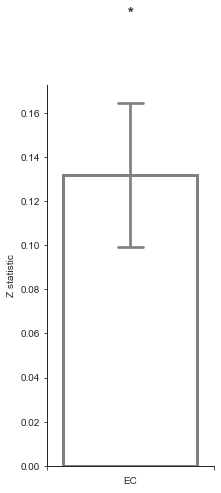

In [61]:
# plot
fig,ax = plt.subplots(figsize=(3,7))
xjitter = np.random.uniform(-0.05, 0.05,size=len(subs_mean_activity))
# Add a point to represent the mean of subs_mean_activity
mean_val = subs_mean_activity.mean()
#plt.plot(0, mean_val*1.02, marker='d', markersize=7,color='royalblue',zorder=10)
sns.barplot(data=subs_mean_activity,    errorbar="se", capsize=.15, errcolor="0.5",
            linewidth=3, edgecolor=".5", facecolor=(0, 0, 0, 0),
            ax=ax)

# Add a horizontal line
ax.hlines(y=0, xmin=-0.45, xmax=0.45, colors='black', linestyles='--',linewidth=0.7)
ax.set_ylabel('Z statistic')
ax.set_xlabel('EC')

# Remove top and right spines
sns.despine(top=True, right=True)

# Modify the bottom and left spines
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set custom ticks for the x-axis and y-axis
plt.xticks([-0.5, 0.5])
#plt.yticks(np.arange(0, 0.25, 0.1))
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Add asterisks on top of each bar
vmean = np.mean(subs_mean_activity)
ax.text(0, subs_mean_activity.mean()+0.07, p2sign(p_value),ha='center', va='bottom',weight='bold',size=15)
#plt.savefig("/mnt/workdir/DCM/Result/paper/sf5/Game2-hexagon_diff_sub-all_roi-RSC-Yeo_mean.pdf", dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)
plt.show()

## Plot ROI covairate effect

In [31]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("(game1_fmri>=0.5)")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexModdistance_spct/Setall/6fold/' \
                r'{}/zmap/hexModdistance_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/cv_test_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_even_zmap.nii.gz'
# cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'

# load roi
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)

#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/lRSC_thr3.1_erosion.nii.gz')
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.posteriorcingulate.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.posteriorcingulate.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.3.24/Nilearn_smodel/game1/hexagon_spct/EC_thr3.1.nii.gz')
# roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# roi = image.binarize_img(roi,5)
# roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')
roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/Park_Grid_ROI/mPFC_GP_roi.nii')

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

r 0.1177 p 0.0944


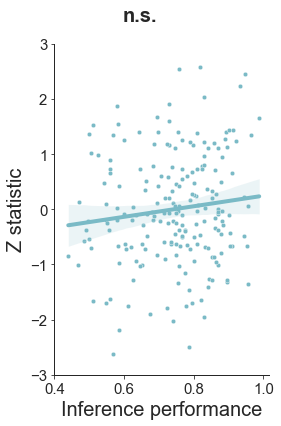

In [37]:
# get covariate
participants_data['beh_diff'] = participants_data['game2_test_acc'] - participants_data['game1_acc']

covariate = 'Acc'
# Setup variables based on covariate
if covariate == 'Age':
    color = '#e36570'
    covary_variable = participants_data['Age'].to_list()
    xlabel = 'Age'
    ticks = [8, 12, 16, 20, 24]

elif covariate == 'Acc':
    color = '#7abac6'
    covary_variable = participants_data['game1_acc'].to_list()
    xlabel = 'Inference performance'
    ticks = [0.4,0.6,0.8,1.0]
else:
    raise ValueError("Invalid covariate value")

# Standardize subs_mean_activity
subs_mean_activity = (np.array(subs_mean_activity) - np.mean(subs_mean_activity)) / np.std(subs_mean_activity)

# Initialize the plot
fig, ax = plt.subplots(figsize=(4,6))
sns.scatterplot(x=covary_variable, y=subs_mean_activity, color=color, s=20, alpha=1)
sns.regplot(x=covary_variable, y=subs_mean_activity, color=color, order=1, scatter=False,line_kws={'linewidth': 4})

# Setup labels and despine
ax.set_xlabel(xlabel, fontsize=20)
ax.set_ylabel('Z statistic', fontsize=20)
sns.despine(top=True, right=True)
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set ticks
plt.ylim([-3, 3])
plt.yticks(size=15)
plt.xticks(ticks, size=15)

# Compute pearson correlation
r, p = pearsonr(covary_variable, subs_mean_activity)
print('r', round(r,4), 'p', round(p,4))

# Add title based on significance level
fig.subplots_adjust(top=0.92)
title = p2sign(p)
fig.suptitle(title, size=20, fontweight='bold')

# Set tick parameters
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Uncomment the lines below if you want to save the figure
fig.tight_layout()
savepath = '/mnt/workdir/DCM/Result/paper/figure3/Park-mPFC/HexModDistance_game1_ROI-Park-mPFC_{}.pdf'.format(covariate)
plt.savefig(savepath, bbox_inches='tight', pad_inches=0, dpi=300, transparent=True)

# Show the plot
plt.show()

## Partial correlation

In [15]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("game2_fmri>=0.5")
subjects_id = data['Participant_ID'].to_list()

# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/{}/zmap/alignPhi_zmap.nii.gz'
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/Setall/6fold/{}/zmap/hexagon_zmap.nii.gz'

# set roi
roi = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
#roi = image.load_img(r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')
# extract mean activity
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

data['Consistency_effect'] = subs_mean_activity
data['Inference_acc'] = data['game2_test_acc']

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
<ipython-input-15-d462c82d24db>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Consistency_effect'] = subs_mean_activity
<ipython-input-15-d462c82d24db>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

                            OLS Regression Results                            
Dep. Variable:          Inference_acc   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     44.14
Date:                Tue, 27 Jun 2023   Prob (F-statistic):           1.81e-16
Time:                        10:32:15   Log-Likelihood:                 130.64
No. Observations:                 193   AIC:                            -255.3
Df Residuals:                     190   BIC:                            -245.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.5299      0

<ipython-input-20-0d3d9caa22de>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


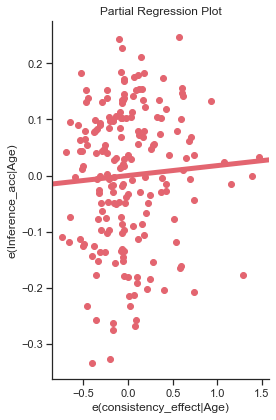

In [20]:
#
X = data[['Consistency_effect','Age']]
Y = data['Inference_acc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# Save the summary to a text file
#with open('/mnt/workdir/DCM/Result/paper/figure4/game2-hexagon_consistency_glm_model_summary.txt', 'w') as f:
#    f.write(model_summary.as_text())

# Plot the partial correlation plot with age held constant
fig = sm.graphics.plot_partregress("Inference_acc", "Consistency_effect",["Age"],data=data,obs_labels=False)

fig.set_size_inches(4,6)
sns.set_theme(style="white")
fig.tight_layout()

# Get the Axes object
ax = fig.get_axes()[0]
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')

# Set custom ticks for the x-axis and y-axis
# plt.xticks([-2, -1, 0, 1, 2])
# plt.yticks([-0.2, 0, 0.2])

# Change color of scatter points and line to 'salmon'
for line in ax.lines:
    line.set_color('#e36570')
    line.set_linewidth(5)
for path in ax.collections:
    path.set_edgecolor('#e36570')

ax.set_xlabel("e(consistency_effect|Age)")
ax.set_ylabel("e(Inference_acc|Age)")

# Save the figure before calling fig.show()
#fig.savefig('/mnt/workdir/DCM/Result/paper/figure4/game2-hexagon_consistency_partial_correlation_plot.pdf', dpi=300, bbox_inches='tight',pad_inches=0,transparent=True)
fig.show()

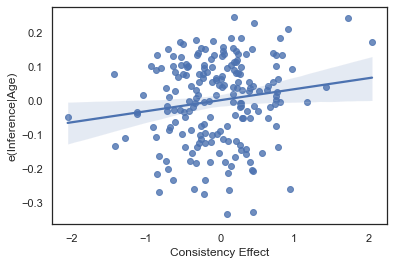

(0.14996218627753405, 0.03737960416515819)

In [197]:
# Fit regression model (using the natural log of one of the regressors)
results = smf.ols('Inference_acc ~ Age', data=data).fit()
results2 = smf.ols('Consistency_effect ~ Age', data=data).fit()
# Create a new DataFrame with the residuals
resid_data = pd.DataFrame({
    'consistency_effect': data['Consistency_effect'],
    'age_resid': results.resid_pearson,
    'inference_accuracy_resid': results.resid
})

# Plot the residuals against one another
sns.regplot(x='consistency_effect', y='inference_accuracy_resid', data=resid_data)
plt.xlabel('Consistency Effect')
plt.ylabel('e(Inference|Age)')
plt.show()

pearsonr(resid_data['consistency_effect'], resid_data['inference_accuracy_resid'])

In [170]:
import pingouin as pg
pg.partial_corr(data,'Consistency_effect','Inference_acc',y_covar='Age',method='pearson')

,n,r,CI95%,p-val
pearson,193,0.149962,"[0.01, 0.29]",0.037883


## Plot brain activity with separate age stage

In [ ]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
participants_data =  participants_data.query("game1_fmri>=0.5")
subjects_id = participants_data['Participant_ID'].to_list()

# set camp
cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/{}/rsa/rsa_ztransf_img_coarse_6fold.nii.gz'


# set roi
#roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')
# roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
# roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# roi1 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.parsorbitalis.nii.gz')
# roi2 = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
# roi = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
roi  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
roi = image.binarize_img(roi,5)
# roi = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexagon_spct/EC_thr3.1.nii.gz')

# get activity in ROI
subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, roi),axis=1)

The group difference bettwen children and adolescents t = -1.025, p = 0.307
The group difference bettwen adolescents and adults t = -1.453, p = 0.149
The group difference bettwen children and adults t = -2.772, p = 0.006


Text(1, 0.6012360958294767, '**')

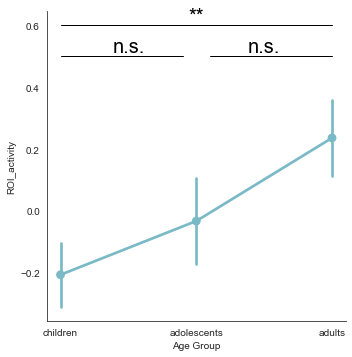

In [37]:
# zscore
subs_mean_activity = (np.array(subs_mean_activity) - np.mean(subs_mean_activity)) / np.std(subs_mean_activity)
participants_data['ROI_activity'] = subs_mean_activity

# Add age group categories
age_bins = [7, 12, 17, 25]
age_labels = ['children', 'adolescents', 'adults']
participants_data['Age_group'] = pd.cut(participants_data['Age'], bins=age_bins, labels=age_labels)

# Plotting
g = sns.catplot(x='Age_group', y='ROI_activity', data=participants_data, kind='point', errorbar="se",color='#7abac6')
g.set_axis_labels("Age Group", "ROI_activity")
g.fig.set_size_inches(5, 5)

# get the acivities of each age group
children_data = participants_data.query("Age_group=='children'")
adolescents_data = participants_data.query("Age_group=='adolescents'")
adult_data = participants_data.query("Age_group=='adults'")

# compare activity size between each pair of the three age groups using t-tests
height = participants_data['ROI_activity'].mean() + 0.5*participants_data['ROI_activity'].std()

# compare children and adolescents
t,p = ttest_ind(children_data['ROI_activity'], adolescents_data['ROI_activity'])
print('The group difference bettwen children and adolescents t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 0.9], [height, height], 'k-', lw=1)
g.ax.text(0.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare children and adults
t,p =  ttest_ind(adolescents_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen adolescents and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([1.1, 2], [height, height], 'k-', lw=1)
g.ax.text(1.5, height, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

# compare adolescents and adults
t,p = ttest_ind(children_data['ROI_activity'], adult_data['ROI_activity'])
print('The group difference bettwen children and adults t = {:.3f}, p = {:.3f}'.format(t, p))
g.ax.plot([0, 2], [height+0.1, height+0.1], 'k-', lw=1)
g.ax.text(1, height+0.1, p2sign(p), ha='center', va='bottom', color='k', fontsize=20)

## Test whether the difference between the correlation coefficients is significant

In [ ]:
import numpy as np
from scipy.stats import t, norm
from math import atanh, pow
from numpy import tanh

# set
a1 = children_data['ROI_activity'].to_numpy()
b1 = children_data['game1_acc'].to_numpy()

a2 = adolescents_data['ROI_activity'].to_numpy()
b2 = adolescents_data['game1_acc'].to_numpy()

# get the correlation coefficients
r1,p1 = pearsonr(a1,b1)
r2,p2 = pearsonr(a2,b2)

# Sample sizes for each correlation coefficient
n1 = len(a1)
n2 = len(a2)
print(r1,p1)
print(r2,p2)

def rz_ci(r, n, conf_level = 0.95):
    zr_se = pow(1/(n - 3), .5)
    moe = norm.ppf(1 - (1 - conf_level)/float(2)) * zr_se
    zu = atanh(r) + moe
    zl = atanh(r) - moe
    return tanh((zl, zu))

def independent_corr(xy, ab, n, n2 = None, twotailed=True, conf_level=0.95, method='fisher'):
    """
    Calculates the statistic significance between two independent correlation coefficients
    @param xy: correlation coefficient between x and y
    @param xz: correlation coefficient between a and b
    @param n: number of elements in xy
    @param n2: number of elements in ab (if distinct from n)
    @param twotailed: whether to calculate a one or two tailed test, only works for 'fisher' method
    @param conf_level: confidence level, only works for 'zou' method
    @param method: defines the method uses, 'fisher' or 'zou'
    @return: z and p-val
    """

    if method == 'fisher':
        xy_z = 0.5 * np.log((1 + xy)/(1 - xy))
        ab_z = 0.5 * np.log((1 + ab)/(1 - ab))
        if n2 is None:
            n2 = n

        se_diff_r = np.sqrt(1/(n - 3) + 1/(n2 - 3))
        diff = xy_z - ab_z
        z = abs(diff / se_diff_r)
        p = (1 - norm.cdf(z))
        if twotailed:
            p *= 2

        return z, p
    elif method == 'zou':
        L1 = rz_ci(xy, n, conf_level=conf_level)[0]
        U1 = rz_ci(xy, n, conf_level=conf_level)[1]
        L2 = rz_ci(ab, n2, conf_level=conf_level)[0]
        U2 = rz_ci(ab, n2, conf_level=conf_level)[1]
        lower = xy - ab - pow((pow((xy - L1), 2) + pow((U2 - ab), 2)), 0.5)
        upper = xy - ab + pow((pow((U1 - xy), 2) + pow((ab - L2), 2)), 0.5)
        return lower, upper
    else:
        raise Exception('Wrong method!')

print(independent_corr(r1 , r2, n1, n2, method='fisher',twotailed=False))

# Mediation analysis

### load data(A)

In [20]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data =  participants_data.query("(game1_fmri>=0.5)")
subjects_id = data['Participant_ID'].to_list()

# load ROI
# # load HC
rHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
lHC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
hc = image.math_img('np.logical_or(img1,img2)', img1=rHC, img2=lHC)
# load EC
# ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
# ec = image.binarize_img(ec,5)
# # # # load OFC
# rlOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.lateralorbitofrontal.nii.gz')
# llOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.lateralorbitofrontal.nii.gz')
# lofc = image.math_img('np.logical_or(img1,img2)', img1=rlOFC, img2=llOFC)
# # # #
# # rpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.parsorbitalis.nii.gz')
# # lpOFC = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.parsorbitalis.nii.gz')
# # ofc = image.math_img('np.logical_or(img1,img2)', img1=rpOFC, img2=lpOFC)
# # # # # load vmPFC
vmPFC  = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/VMPFC_merge_MNI152NL.nii.gz')

# load dmPFC
dmPFC = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/BN_dmPFC_middle.nii.gz')
# # # # # load PCC
rpcc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/lh.posteriorcingulate.nii.gz')
lpcc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/aparc/mask/rh.posteriorcingulate.nii.gz')
pcc = image.math_img('np.logical_or(img1,img2)', img1=rpcc, img2=lpcc)
# # put ROIs into a dict
rois = {'vmPFC':vmPFC,'PCC':pcc,'HC':hc,'dmPFC':dmPFC}
#rois = {'EC':ec}
# # load isthmuscingulate
# liscc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/lh.isthmuscingulate.nii.gz')
# riscc = image.load_img(r'/mnt/data/DCM/tmp/aparc/mask/rh.isthmuscingulate.nii.gz')
# iscc = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
# rois = {'liscc':liscc,'riscc':riscc,'iscc':iscc}
# set camp
#cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'

cmap_template = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/2distance_spct/Setall/6fold/{}/zmap/m2xeucd_zmap.nii.gz'

# get each subject's activity in each ROI
for troi_name,troi in rois.items():
    print(troi_name,'is processing')
    # get activity in ROI
    subs_cmap_list = [cmap_template.format(sub_id) for sub_id in subjects_id]
    subs_mean_activity = np.mean(masking.apply_mask(subs_cmap_list, troi),axis=1)
    data[troi_name] = subs_mean_activity
print(len(subs_mean_activity))

vmPFC is processing


<ipython-input-20-945e93245464>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[troi_name] = subs_mean_activity


PCC is processing
HC is processing
dmPFC is processing
203


### load data(B)

In [65]:
# check whether the manhattan distance can predict/meidate value effect and inference accuracy

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('game1_fmri>=0.5')  # look out
subjects = data['Participant_ID'].to_list()

# set cmp template
rsa_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/grid_rsa_corr_trials/Setall/6fold/' \
           r'{}/rsa/rsa_zscore_img_coarse_6fold.nii.gz'
# rsa_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game2/cv_hexagon_spct/Setall/6fold/' \
#            r'{}/zmap/alignPhi_zmap.nii.gz'
# distance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/' \
#                 r'{}/zmap/M2_corrxdistance_zmap.nii.gz'
# value_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'
distance_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/distance_zmap.nii.gz'
# distance_zmap = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/hexModdistance_spct/Setall/6fold/{}/zmap/hexModdistance_zmap.nii.gz'
# #
value_zmap = r'/mnt/data/DCM/result_backup/2023.5.14/Nilearn/game1/value_spct/Setall/6fold/{}/zmap/value_zmap.nii.gz'

sub_rsa_zmap = [rsa_zmap.format(sub) for sub in subjects]
sub_distance_zmap = [distance_zmap.format(sub) for sub in subjects]
sub_value_zmap = [value_zmap.format(sub) for sub in subjects]

ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,5)
mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/Park_Grid_ROI/mPFC_GP_roi.nii')
#mpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/mPFC/BiMPFC_NeuroSynth_MNINL.nii.gz')
#dmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')
#dmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/DMN_and_EMO_or_SOC__dmPFC_MNINL.nii.gz')
vmpfc_bin = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/VMPFC/vmPFC_bin.nii.gz')

#dmpfc = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/dmPFC/dmPFC_closed_dilated_resampled.nii.gz')
# extract mean activity of ROI for each subjects
data['hexagon'] = np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
data['distance'] = np.mean(masking.apply_mask(sub_distance_zmap, mpfc), axis=1)
data['value'] = np.mean(masking.apply_mask(sub_value_zmap,mpfc ), axis=1)

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the columns and transform
data[['hexagon', 'distance', 'Age', 'game1_acc', 'value']] = scaler.fit_transform(data[['hexagon', 'distance','Age','game1_acc', 'value']])
#data[['Age','game1_acc','distance']] = scaler.fit_transform(data[['Age','game1_acc','distance']])

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)
<ipython-input-65-ab8db0a87fb7>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['hexagon'] = np.mean(masking.apply_mask(sub_rsa_zmap, ec), axis=1)
<ipython-input-65-ab8db0a87fb7>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Multiple regression

In [149]:
# using GLM to predict inference accuracy from brain activity and age
data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']
X = data[['hexagon','distance']]
Y = data['game1_acc']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)
model_summary = model.summary()
print(model_summary)

# 将摘要保存到文件
# summary_file = '/mnt/workdir/DCM/Result/paper/figure3/Value/Value_mPFC-meidaiton-glm1_summary.txt'
# with open(summary_file, 'w') as f:
#     f.write(model_summary.as_text())
#     f.close()

                            OLS Regression Results                            
Dep. Variable:              game1_acc   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     12.01
Date:                Fri, 30 Jun 2023   Prob (F-statistic):           1.18e-05
Time:                        18:10:25   Log-Likelihood:                -276.53
No. Observations:                 203   AIC:                             559.1
Df Residuals:                     200   BIC:                             569.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.482e-16      0.067   -8.2e-15      1.0

<ipython-input-149-9803be257b39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['beh_diff'] = data['game2_test_acc'] - data['game1_acc']


### Mediation analysis(A)

In [67]:
import pingouin as pg
from sklearn.preprocessing import StandardScaler

iv = 'Age'
m = ['value']
dv = 'game1_acc'
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the columns and transform
#data[['distance','Age','game2_test_acc']] = scaler.fit_transform(data[['distance','Age','game2_test_acc']])

# Mediation analysis
mediation_results,indirect_beta_sample = pg.mediation_analysis(data=data, x=iv, m=m, y=dv, seed=42,n_boot=10000,return_dist=True)

# save results
mediation_results.to_csv(r'/mnt/workdir/DCM/Result/paper/figure3/value_mPFC_mediation.csv',index=False)
np.save(r'/mnt/workdir/DCM/Result/paper/figure3/Indirect_beta_sample_value_mPFC.npy',indirect_beta_sample)

In [68]:
mediation_results.round(3)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,value ~ X,0.060,0.070,0.398,-0.079,0.198,No
1,Y ~ value,0.035,0.070,0.618,-0.104,0.174,No
2,Total,0.556,0.059,0.000,0.440,0.671,Yes
3,Direct,0.556,0.059,0.000,0.439,0.672,Yes
4,Indirect,0.000,0.005,0.978,-0.010,0.013,No


### Mediation analysis(B)

In [17]:
def bootstrap_indirect_effect(data, iv, m, dv, n_bootstraps=5000, ci=0.95):
    indirect_effects = []
    for _ in range(n_bootstraps):
        bootstrap_data = data.sample(frac=1, replace=True)

        path_a = smf.ols(f"{m} ~ {iv}", data=bootstrap_data).fit()
        path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=bootstrap_data).fit()

        indirect_effect = path_a.params[1] * path_b.params[1]
        indirect_effects.append(indirect_effect)

    lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
    upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)

    return lower, upper,indirect_effects

# Replace 'IV', 'M', and 'DV' with the actual variable names in your dataset
iv = 'Age'
m = 'hexagon'
dv = 'game1_acc'

# Path a: IV -> M
path_a = smf.ols(f"{m} ~ {iv}", data=data).fit()

# Path b: M -> DV, controlling for IV
path_b = smf.ols(f"{dv} ~ {m} + {iv}", data=data).fit()
lower, upper,indirect_effects = bootstrap_indirect_effect(data, iv, m, dv,5000)
print(f"Bootstrapped {int(0.95 * 100)}% confidence interval for the indirect effect: ({lower:.8f}, {upper:.8f})")

Bootstrapped 95% confidence interval for the indirect effect: (0.00341708, 0.07773135)


### Plot bootstrap distribution of indirect effect

mean: 0.03623399526694947
standard error: 0.019392967203741732


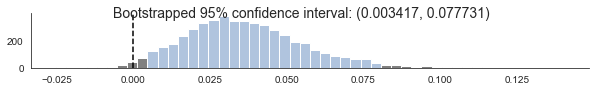

In [18]:
# Calculate lower and upper bounds
ci=0.95
lower = np.percentile(indirect_effects, (1 - ci) / 2 * 100)
upper = np.percentile(indirect_effects, (1 + ci) / 2 * 100)
print('mean:',np.mean(indirect_effects))
print('standard error:',np.std(indirect_effects))
# Plot histogram
fig, ax = plt.subplots(figsize=(10,1))
n, bins, patches = ax.hist(indirect_effects, color='gray',bins=50)

# Find the bin with the highest frequency and its corresponding height
max_height = max(n)
max_height_index = np.where(n == max_height)[0][0]
max_height_bin = bins[max_height_index]

# Add vertical line at zero with height equal to the maximum frequency
ax.axvline(x=0, ymin=0, ymax=max_height, color='black', linestyle='--')

# Color the histogram between the lower and upper bounds blue
for i in range(len(patches)):
    if lower <= bins[i] < upper:
        patches[i].set_fc('lightsteelblue')

# Remove top and right spines
fig.suptitle(f"Bootstrapped {int(ci * 100)}% confidence interval: ({lower:.6f}, {upper:.6f})",size=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# savepath = r'/mnt/workdir/DCM/Result/paper/figure3/Value_vmpfc-meidaiton-age2inference.pdf'
# plt.savefig(savepath,bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)